# Setup

In [1]:
#Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import OPTICS
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
# Working directories
current_dir = os.getcwd()
print("Notebooks directory:", current_dir)
parent_dir = os.path.dirname(current_dir)
print("Local working directory:", parent_dir)
data_dir = parent_dir+"/data/"
print("Data directory:", data_dir)

Notebooks directory: d:\WQU\CAPSTONE\WQU-Capstone\notebooks
Local working directory: d:\WQU\CAPSTONE\WQU-Capstone
Data directory: d:\WQU\CAPSTONE\WQU-Capstone/data/


# Import Data

In [4]:


pkl_data = data_dir + "etf_data_with_indicators.pkl"
etf_data = pd.read_pickle(pkl_data)


In [5]:
# Check the shape of the data
print(f"Number of ETFs: {len(etf_data)}")
print(f"Sample ETF data shape: {next(iter(etf_data.values())).shape}")

Number of ETFs: 75
Sample ETF data shape: (1761, 23)


In [6]:
# Create a combined dataframe with all ETFs' closing prices
etf_keys = list(etf_data.keys())
close_prices = pd.DataFrame()

In [7]:
# Extract closing prices for all ETFs
for ticker in etf_keys:
    if 'adjClose' in etf_data[ticker].columns:
        close_prices[ticker] = etf_data[ticker]['adjClose']

In [8]:
# Handle missing values
close_prices = close_prices.dropna(axis=0, how='any')
print(f"Price data shape after dropping NAs: {close_prices.shape}")

Price data shape after dropping NAs: (1760, 75)


In [9]:
# Calculate returns for PCA
returns = close_prices.pct_change().dropna()
print(f"Returns data shape: {returns.shape}")

Returns data shape: (1759, 75)


In [10]:
# Apply StandardScaler to returns
scaler = StandardScaler()
scaled_returns = pd.DataFrame(
    scaler.fit_transform(returns),
    index=returns.index,
    columns=returns.columns
)
# Transpose the scaled returns for PCA
scaled_returns = scaled_returns.T

# Applying PCA

In [21]:
# Setting components to 5
n_components = 6
pca = PCA(n_components=n_components, random_state=42)
principal_components = pca.fit_transform(scaled_returns)

In [22]:
# Analyze explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

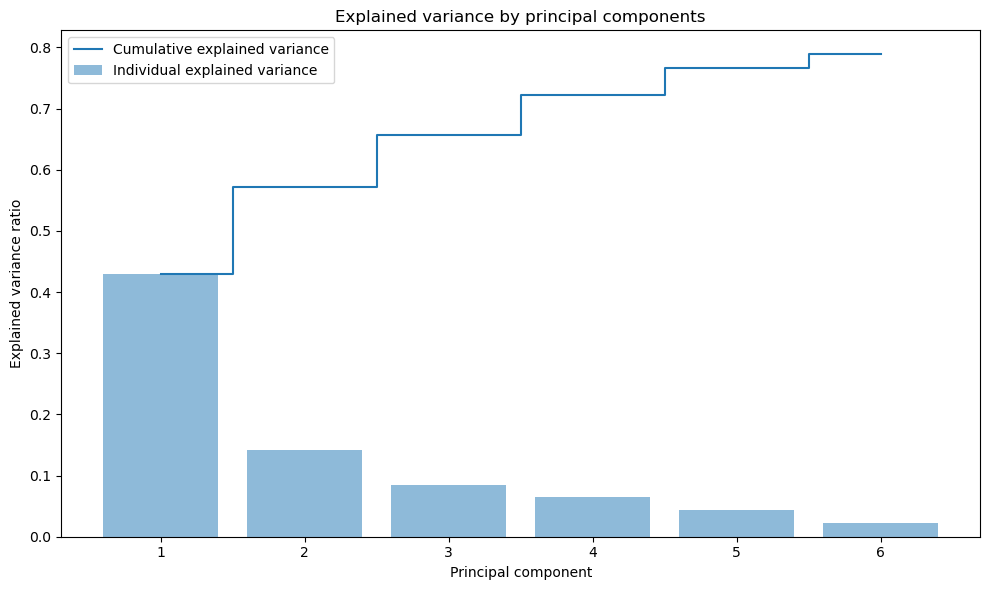

In [23]:
# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, n_components + 1), cumulative_variance, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.title('Explained variance by principal components')
plt.tight_layout()
plt.show()

# Applying OPTICS

In [28]:
#clustering on the principal components
optics_clustering = OPTICS(
    min_samples=2,           # Reduce from default (usually 5)
    max_eps=2.0,             # Increase max_eps
    metric='euclidean',
    cluster_method='xi',     # Try 'xi' method
    xi=0.05                  # Lower xi value makes it easier to form clusters
)
cluster_labels = optics_clustering.fit_predict(principal_components)

In [29]:
# Convert to pandas Series for easier handling
indices = scaled_returns.index  # Use the index of scaled_returns, which matches principal_components
clustered_series = pd.Series(cluster_labels, index=indices)
# Count ETFs per cluster
cluster_counts = pd.Series(clustered_series[clustered_series != -1].value_counts()).sort_index()
print(f"Clusters discovered: {len(cluster_counts)}")
print(f"Average cluster size: {np.mean(cluster_counts)}")
print(cluster_counts)

Clusters discovered: 12
Average cluster size: 2.0833333333333335
0     2
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     3
10    2
11    2
Name: count, dtype: int64


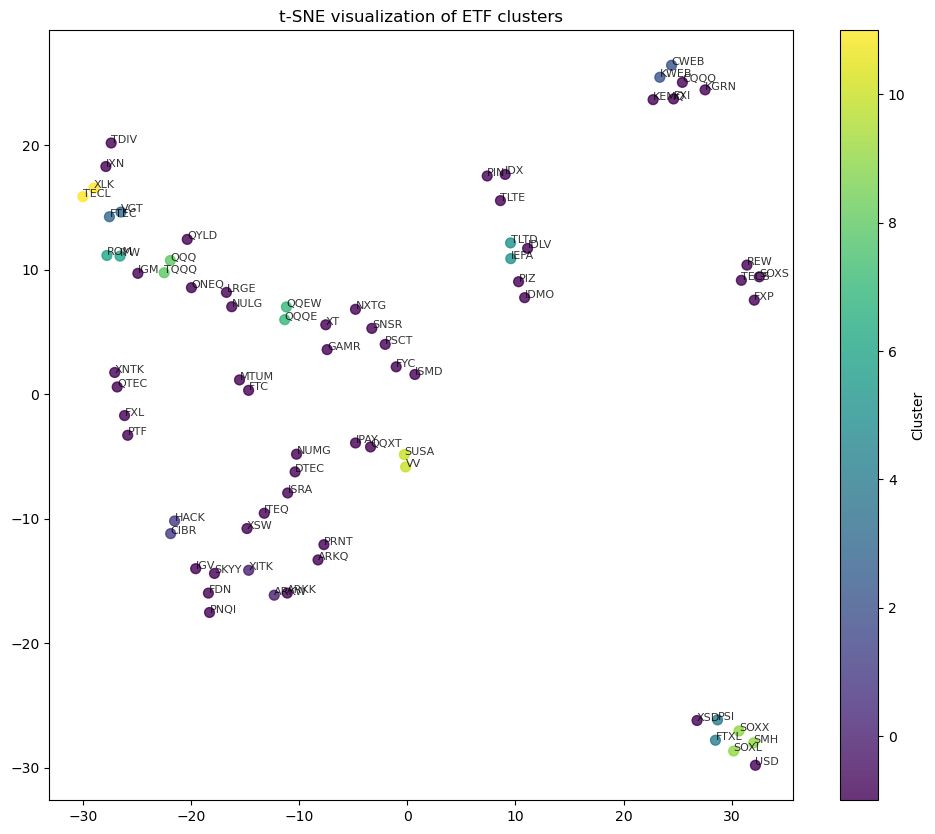


Cluster 0:
Number of ETFs: 2
Tickers: ARKW, XITK

Cluster 1:
Number of ETFs: 2
Tickers: CIBR, HACK

Cluster 2:
Number of ETFs: 2
Tickers: CWEB, KWEB

Cluster 3:
Number of ETFs: 2
Tickers: FTEC, VGT

Cluster 4:
Number of ETFs: 2
Tickers: FTXL, PSI

Cluster 5:
Number of ETFs: 2
Tickers: IEFA, TLTD

Cluster 6:
Number of ETFs: 2
Tickers: IYW, ROM

Cluster 7:
Number of ETFs: 2
Tickers: QQEW, QQQE

Cluster 8:
Number of ETFs: 2
Tickers: QQQ, TQQQ

Cluster 9:
Number of ETFs: 3
Tickers: SMH, SOXL, SOXX

Cluster 10:
Number of ETFs: 2
Tickers: SUSA, VV

Cluster 11:
Number of ETFs: 2
Tickers: TECL, XLK


In [30]:

unique_clusters = sorted(set([label for label in cluster_labels if label != -1]))

# Create a mapping from original labels to new sequential labels starting from 0
cluster_mapping = {-1: -1}  # Keep noise points as -1
for i, cluster_id in enumerate(unique_clusters):
    cluster_mapping[cluster_id] = i

# Apply the mapping to get new cluster labels
remapped_labels = np.array([cluster_mapping[label] for label in cluster_labels])

# Use remapped_labels for visualization instead of cluster_labels
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                     c=remapped_labels, cmap='viridis', 
                     alpha=0.8, s=50)
plt.colorbar(scatter, label='Cluster')

# Add ticker labels
for i, ticker in enumerate(close_prices.columns):
    plt.annotate(ticker, (tsne_results[i, 0], tsne_results[i, 1]), 
                fontsize=8, alpha=0.8)

plt.title('t-SNE visualization of ETF clusters')
plt.savefig('tsne_etf_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

# Also use remapped_labels for the cluster analysis section
for cluster_id in sorted(set(remapped_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get tickers in this cluster
    mask = remapped_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    print(f"\nCluster {cluster_id}:")
    print(f"Number of ETFs: {len(tickers_in_cluster)}")
    print(f"Tickers: {', '.join(tickers_in_cluster)}")
    
    # Plot the normalized price series for this cluster
    

In [31]:
# Analyze noise points (if any)
noise_mask = remapped_labels == -1
noise_tickers = close_prices.columns[noise_mask]
if len(noise_tickers) > 0:
    print("\nNoise points (outliers):")
    print(f"Number of ETFs: {len(noise_tickers)}")
    print(f"Tickers: {', '.join(noise_tickers)}")


Noise points (outliers):
Number of ETFs: 50
Tickers: ARKK, ARKQ, CQQQ, DTEC, FDN, FTC, FXI, FXL, FXP, FYC, GAMR, IDLV, IDMO, IDX, IGM, IGV, IPAY, ISMD, ISRA, ITEQ, IXN, KEMQ, KGRN, LRGE, MTUM, NULG, NUMG, NXTG, ONEQ, PIN, PIZ, PNQI, PRNT, PSCT, PTF, QQXT, QTEC, QYLD, REW, SKYY, SNSR, SOXS, TDIV, TECS, TLTE, USD, XNTK, XSD, XSW, XT


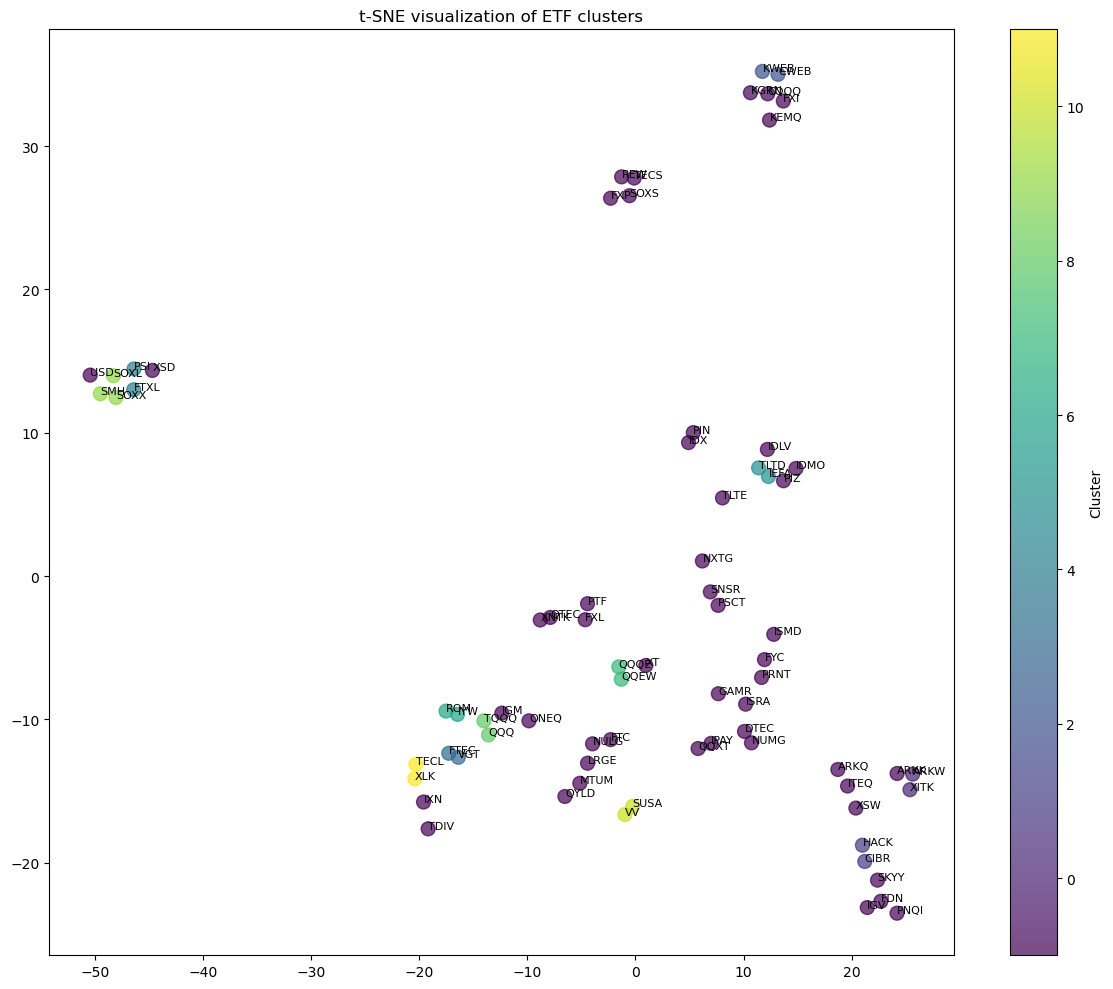

In [32]:
# Visualize clusters with t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
tsne_results = tsne.fit_transform(principal_components)

# Plot t-SNE results
plt.figure(figsize=(12, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7, s=100)
plt.colorbar(scatter, label='Cluster')
# Add ticker labels
for i, ticker in enumerate(close_prices.columns):
    plt.annotate(ticker, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)

plt.title('t-SNE visualization of ETF clusters')
plt.tight_layout()
plt.savefig('PCA_OPTICS_clusters_tsne.png', dpi=150)
plt.show()


Cluster 0:
Number of ETFs: 2
Tickers: ARKW, XITK


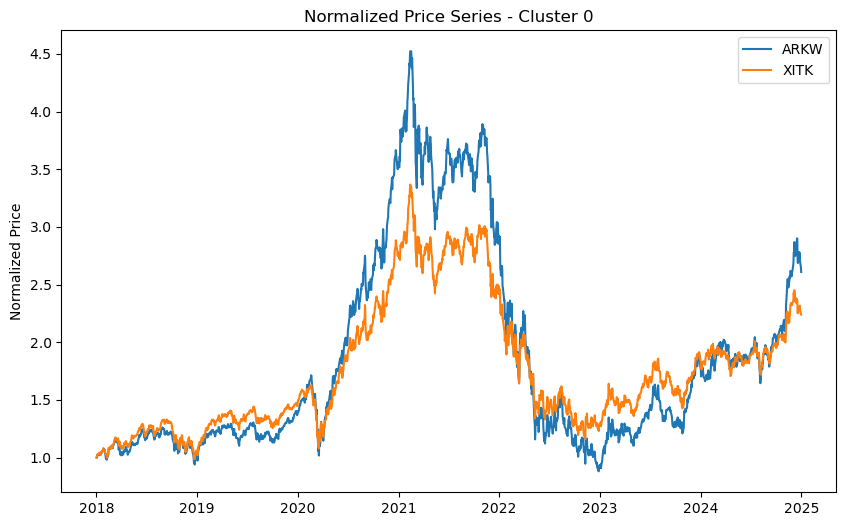


Cluster 1:
Number of ETFs: 2
Tickers: CIBR, HACK


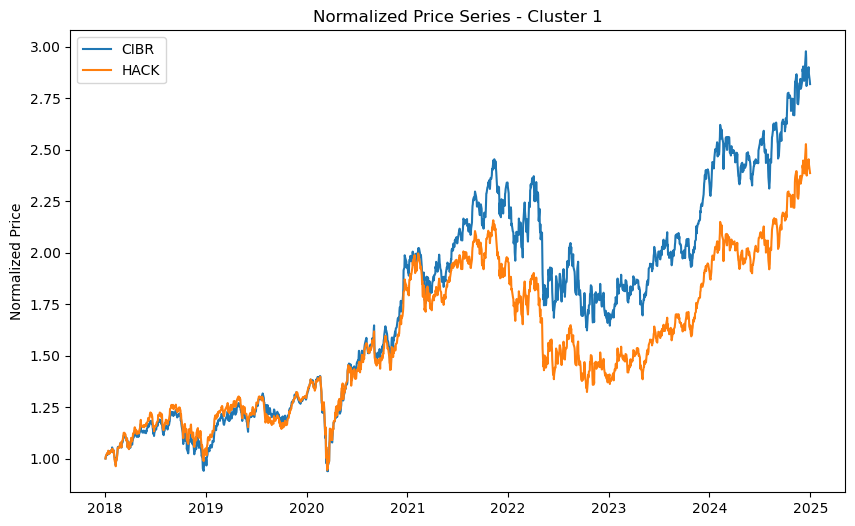


Cluster 2:
Number of ETFs: 2
Tickers: CWEB, KWEB


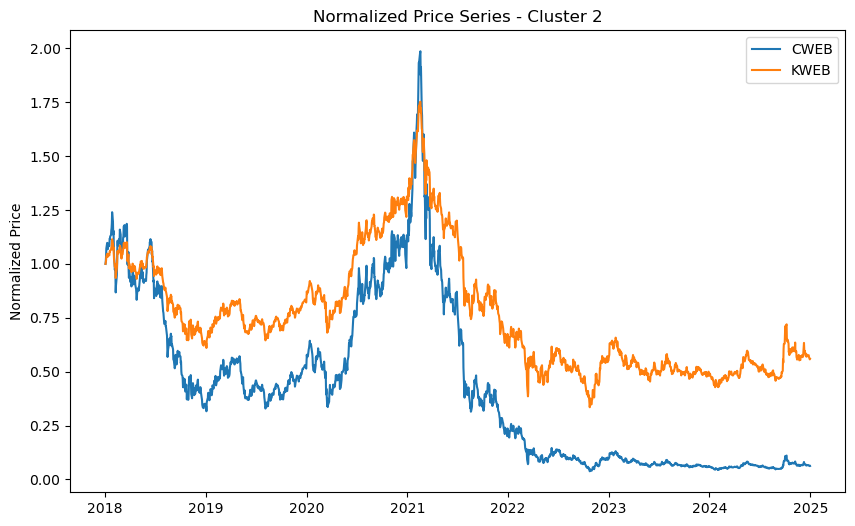


Cluster 3:
Number of ETFs: 2
Tickers: FTEC, VGT


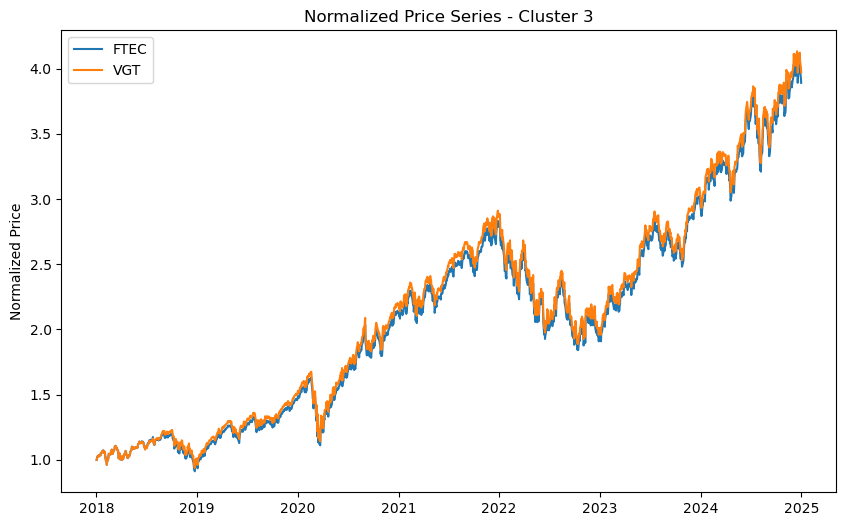


Cluster 4:
Number of ETFs: 2
Tickers: FTXL, PSI


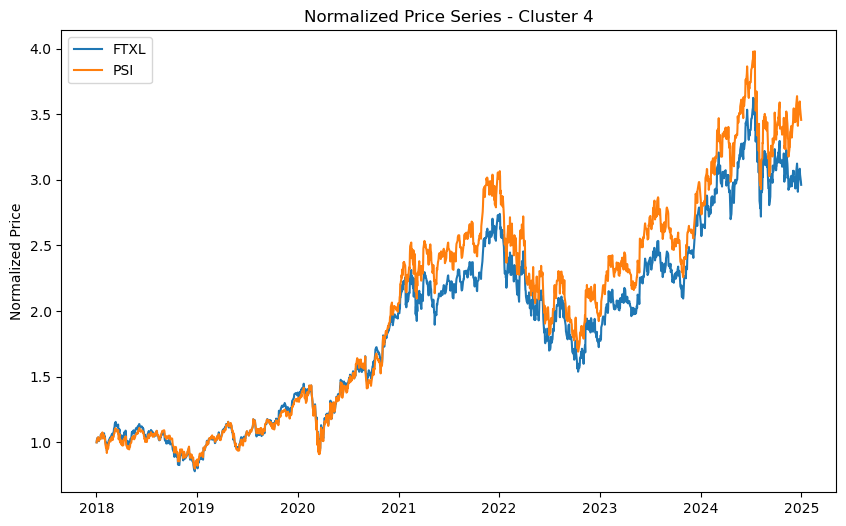


Cluster 5:
Number of ETFs: 2
Tickers: IEFA, TLTD


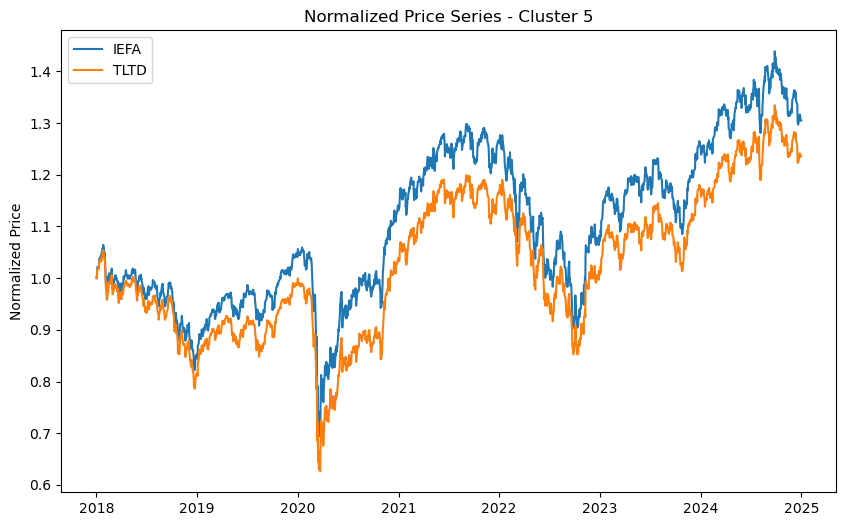


Cluster 6:
Number of ETFs: 2
Tickers: IYW, ROM


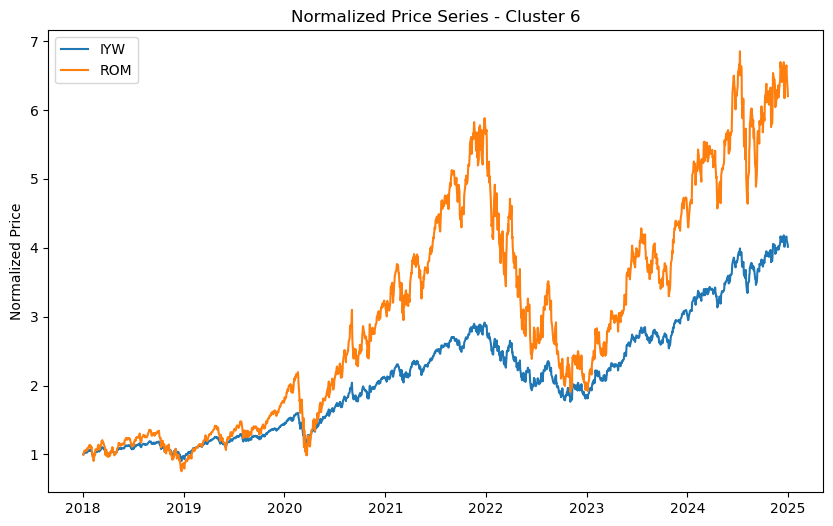


Cluster 7:
Number of ETFs: 2
Tickers: QQEW, QQQE


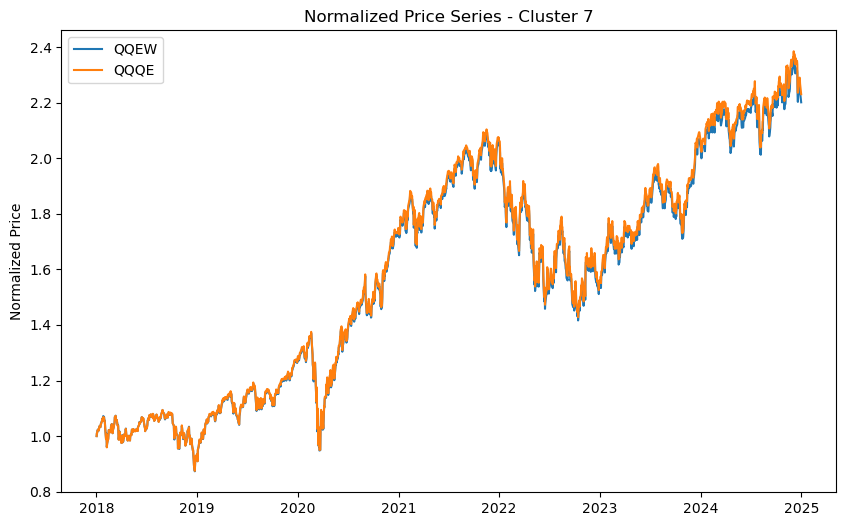


Cluster 8:
Number of ETFs: 2
Tickers: QQQ, TQQQ


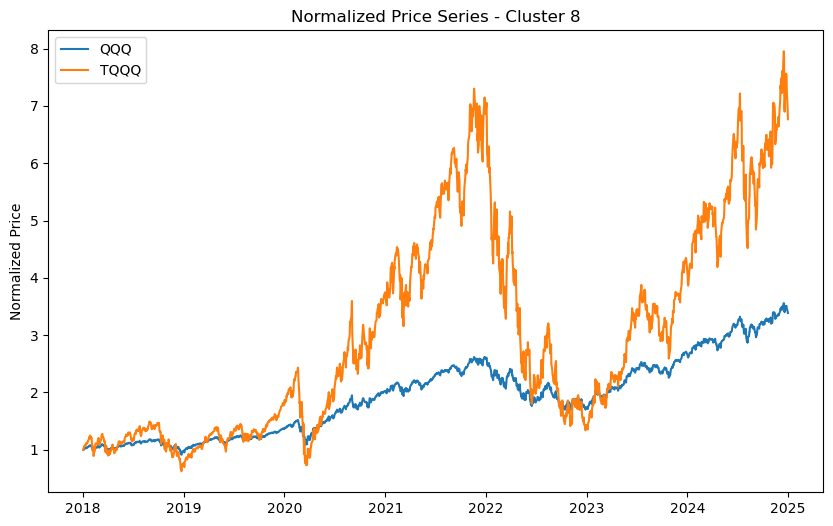


Cluster 9:
Number of ETFs: 3
Tickers: SMH, SOXL, SOXX


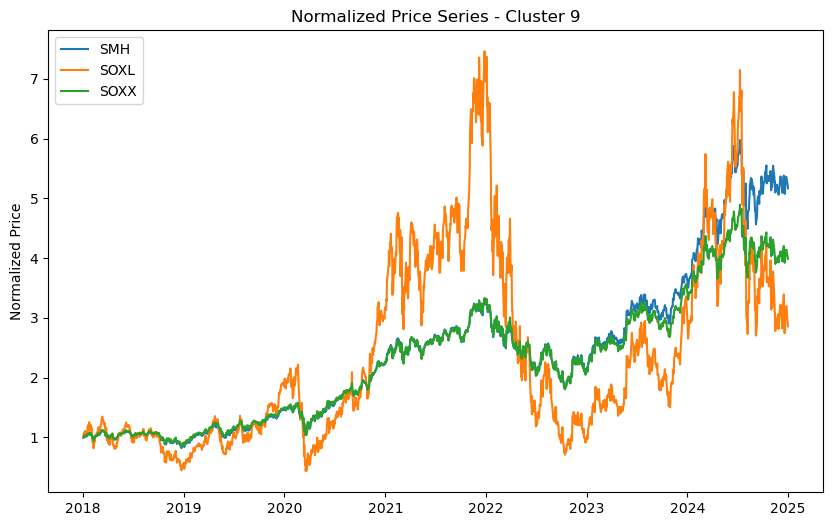


Cluster 10:
Number of ETFs: 2
Tickers: SUSA, VV


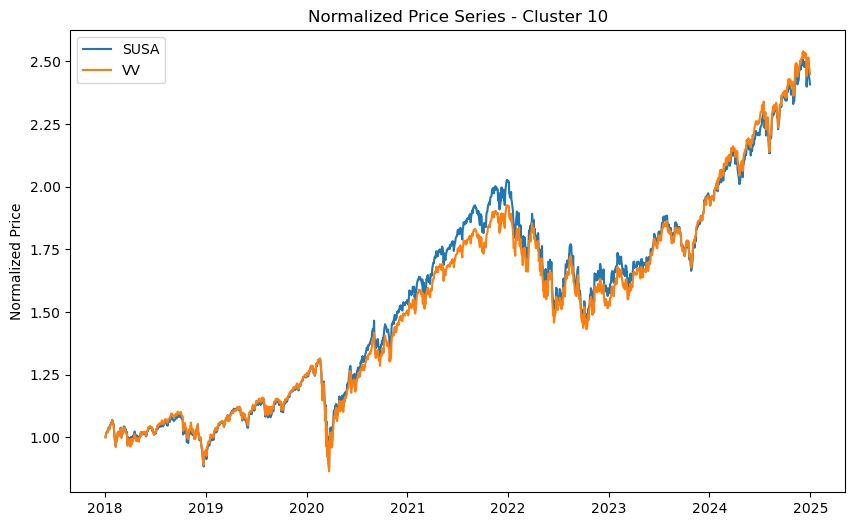


Cluster 11:
Number of ETFs: 2
Tickers: TECL, XLK


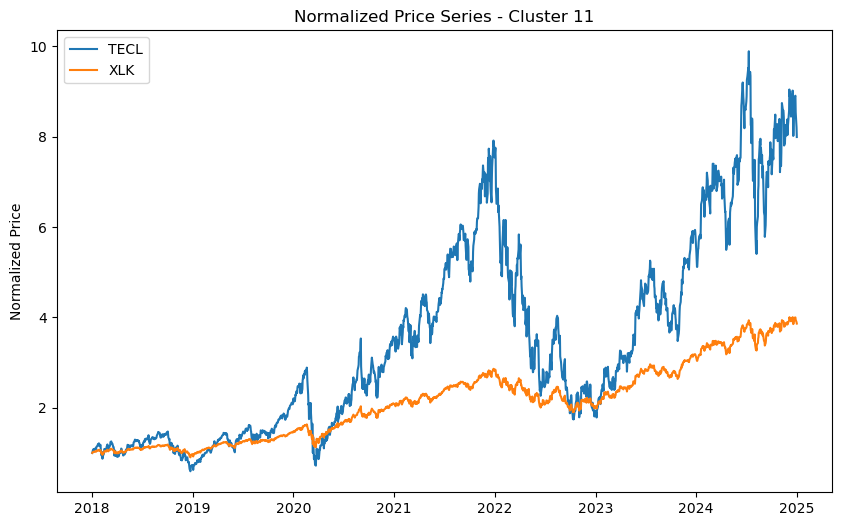

In [33]:
# Analyze clusters
for cluster_id in sorted(set(cluster_labels)):
    if cluster_id == -1:
        continue  # Skip noise points
        
    # Get tickers in this cluster
    mask = cluster_labels == cluster_id
    tickers_in_cluster = close_prices.columns[mask]
    print(f"\nCluster {cluster_id}:")
    print(f"Number of ETFs: {len(tickers_in_cluster)}")
    print(f"Tickers: {', '.join(tickers_in_cluster)}")
    
    # Plot the normalized price series for this cluster
    plt.figure(figsize=(10, 6))
    for ticker in tickers_in_cluster:
        # Normalize to start at 1
        normalized_prices = close_prices[ticker] / close_prices[ticker].iloc[0]
        plt.plot(normalized_prices, label=ticker)
    
    plt.title(f'Normalized Price Series - Cluster {cluster_id}')
    plt.ylabel('Normalized Price')
    plt.legend(loc='best')
    plt.savefig(f'cluster_{cluster_id}_prices.png', dpi=300, bbox_inches='tight')
    plt.show()